## Capstone - Sentiment Based Product Recommendation System

## Problem Statement

To build a model that will improve the recommendations given to the users given their past reviews and ratings.

So we build a sentiment-based product recommendation system, which includes the following tasks.

Data sourcing and sentiment analysis Building a recommendation system Improving the recommendations using the sentiment analysis model Deploying the end-to-end project with a user interface

In [1]:
## Importing all Necessary Libraries

# dataframe and series
import pandas as pd
import numpy as np

# To plot
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
#from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string
from wordcloud import WordCloud


# sklearn imports for modeling part
from sklearn.model_selection  import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
import pickle
import calendar

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sklearn
print(sklearn.__version__)
print(np.__version__)
print(pd.__version__)
print(nltk.__version__)


1.0.2
1.19.2
1.1.3
3.5


### Load the Dataset

In [3]:
reviews = pd.read_csv('dataset\sample30.csv') #getting main data
reviews.head()#first look to df

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [4]:
pd.set_option('max_colwidth',None)  # To see the hidden columns in dataframe
reviews.head(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive


### Exploratory Data Analysis - Data Cleaning and Preprocessing

In [5]:
reviews.shape  #to see the number of columns and rows

(30000, 15)

In [6]:
reviews.info()  #to see the type of columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [7]:
reviews.describe() 

,reviews_rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [8]:
reviews.isnull().sum() # to check blanks

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [9]:
reviews = reviews[~reviews['user_sentiment'].isna()]  # Remove the missing row of user_sentiment
reviews.shape 

(29999, 15)

In [10]:
reviews.user_sentiment 

0        Positive
1        Positive
2        Positive
3        Negative
4        Negative
           ...   
29995    Positive
29996    Positive
29997    Positive
29998    Positive
29999    Positive
Name: user_sentiment, Length: 29999, dtype: object

In [11]:
#we see above series has 2 values - postive & negative., lets convert it to 0's and 1's.

reviews['user_sentiment']= reviews['user_sentiment'].map({'Negative':0,'Positive':1})

In [12]:
#get the value count of user_sentiments column in %

reviews['user_sentiment'].value_counts(normalize=True)

1    0.887763
0    0.112237
Name: user_sentiment, dtype: float64

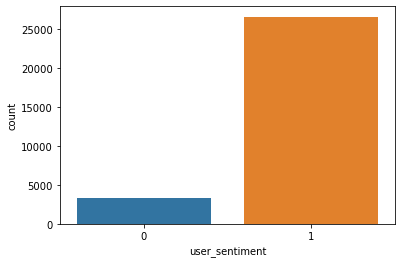

In [13]:
#Visualize using count plot

plt.figure(figsize=(6,4))
sns.countplot(reviews['user_sentiment'])
plt.show()

We notice there is a Class Imbalance clearly so it must be handled during modelling.

In [14]:
#Lets review the ratings in reviews_rating column

reviews['reviews_rating'].value_counts()

5    20830
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

<AxesSubplot:xlabel='reviews_rating', ylabel='count'>

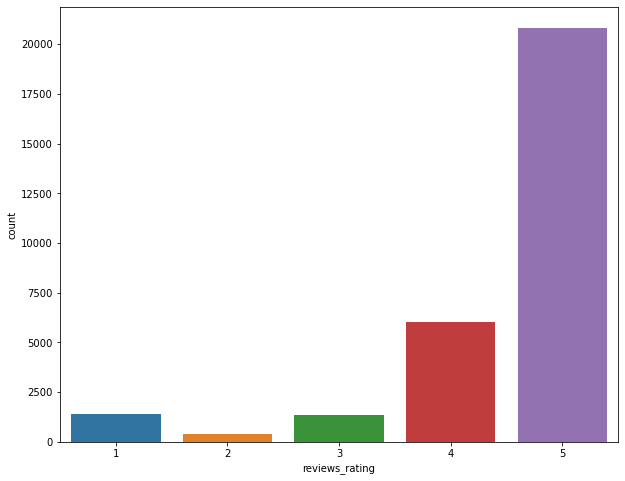

In [15]:
#visualize the user_rating..

plt.figure(figsize=(10,8))
sns.countplot(reviews['reviews_rating'])


In [16]:
#Also lets see the details of postive and negative ratings

print("+Ve User Sentiment : \n\n",reviews[reviews['user_sentiment']==1]['reviews_rating'].describe()),
print("\n**************************************************")
print("\n -Ve User Sentiment : \n\n",reviews[reviews['user_sentiment']==0]['reviews_rating'].describe())

+Ve User Sentiment : 

 count    26632.000000
mean         4.560378
std          0.865194
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews_rating, dtype: float64

**************************************************

 -Ve User Sentiment : 

 count    3367.000000
mean        3.871993
std         1.537589
min         1.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: reviews_rating, dtype: float64


In [17]:
#To find all that has positive sentiment that has lesser ratings( below 4 )

reviews[(reviews['reviews_rating']<=3) & (reviews['user_sentiment']==1)][["reviews_title","reviews_text", "reviews_rating","user_sentiment"]].head()

,reviews_title,reviews_text,reviews_rating,user_sentiment
9,Don't buy,Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund,1,1
11,Waste of Money,Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.,1,1
14,Disappointed,First time purchase of this type of product. Maybe I expected too much. Did not think there was any warming feeling at all. Left us sticky! Even after trying to was it off.,1,1
18,Pretty nice,"I bought this because it had better reviews than the his and hers jelly, but I feel like it didn't work that well for us. It was kind of warm-feeling, but that's about it. I guess I don't know what's supposed to happen! Lol",3,1
54,New formula is terrible,"I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product.",1,1


In [18]:

reviews[(reviews['reviews_rating']<=3) & (reviews['user_sentiment']==1)][["reviews_title","reviews_text", "reviews_rating"]].shape

(2192, 3)

In [19]:
#To find all that has Negative sentiment that has higher ratings( 4 and above)

reviews[(reviews['reviews_rating']>3) & (reviews['user_sentiment']==0)][["reviews_title","reviews_text", "reviews_rating","user_sentiment"]].head()

,reviews_title,reviews_text,reviews_rating,user_sentiment
92,hydrating but not too heavy,It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.,4,0
96,This product has made a real difference on my skin,In only a week I can see the difference in my skin on my face. This review was collected as part of a promotion.,4,0
100,Noticed a difference in just two weeks!,This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. This review was collected as part of a promotion.,4,0
106,Very rich cream,"I like to use this cream on my neck and collarbone to help keep my skin well moisturized, but it can be a little heavy for the skin on my face This review was collected as part of a promotion.",4,0
117,Not greasy,"I finally found a moisturizing product that will absorb completely and not leave my skin feeling like it's suffocating. I apply it, and it feels like there is nothing there but my skin looks smoother. This review was collected as part of a promotion.",4,0


In [20]:
reviews[(reviews['reviews_rating']>3) & (reviews['user_sentiment']==0)][["reviews_title","reviews_text", "reviews_rating"]].shape

(2410, 3)

In [21]:
pd.crosstab(reviews['user_sentiment'], reviews['reviews_rating'],margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,597,140,220,550,1860,3367
1,787,280,1125,5470,18970,26632
All,1384,420,1345,6020,20830,29999


As per the above results, looks like we have few mismtach between review_rating vs user_sentiment. 
There are records with higher user rating but sentiment is negative 
and lower user rating but sentiment is positive. 

We need to clean up those by updating the user sentiments.

In [22]:
reviews.loc[(reviews['reviews_rating']>3) & (reviews['user_sentiment']==0),'user_sentiment'] = 1

In [23]:
reviews.loc[(reviews['reviews_rating']<=3) & (reviews['user_sentiment']==1),'user_sentiment'] = 0

In [24]:
#Post clean up
pd.crosstab(reviews['user_sentiment'], reviews['reviews_rating'],margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,1384,420,1345,0,0,3149
1,0,0,0,6020,20830,26850
All,1384,420,1345,6020,20830,29999


In [25]:
reviews['user_sentiment'].value_counts(normalize=False)

1    26850
0     3149
Name: user_sentiment, dtype: int64

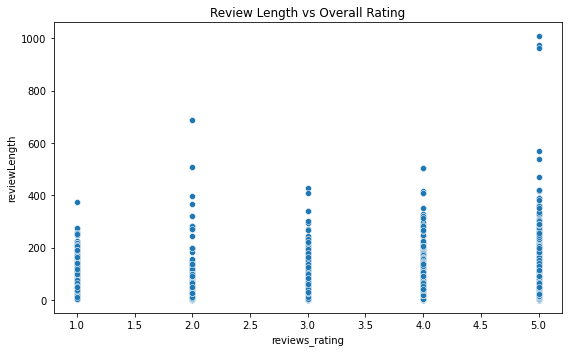

In [26]:
# Distribution of length of reviews vs overall rating

df_reviews = reviews[['id','reviews_username','reviews_text','reviews_title','reviews_rating']]
df_reviews['reviewLength'] = df_reviews['reviews_text'].apply(lambda x: len(x.split()))

f = plt.figure(figsize=(8,5))
reviewLength_vs_Rating = df_reviews[['id','reviewLength','reviews_rating']]
reviewLength_vs_Rating = sns.scatterplot(x='reviews_rating', y='reviewLength', data=reviewLength_vs_Rating)
reviewLength_vs_Rating.set_title('Review Length vs Overall Rating')

f.tight_layout()

from the above plot we can see that rating and review length are related to each other.

<AxesSubplot:xlabel='brand'>

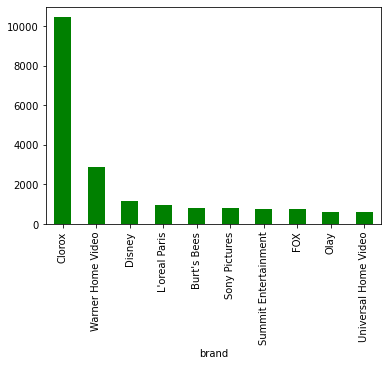

In [27]:
# Filter the top 10 brands among the positive sentiments

reviews[reviews['user_sentiment']==1].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar',color='g')

<AxesSubplot:xlabel='brand'>

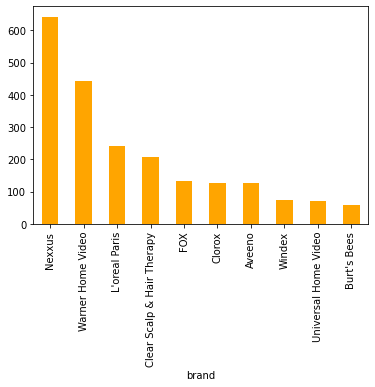

In [28]:
# Filter the top 10 brands among the negative sentiments

reviews[reviews['user_sentiment']==0].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar',color='orange')

The brand "Clorox" has the most positive reviews from customers and the brand "Nexus" has the most negative reviews from its customers

In [29]:
#Let's find out the most common users.
reviews["reviews_username"].value_counts()[:10]

byamazon customer    41
mike                 41
chris                32
lisa                 16
tony                 15
sandy                15
rick                 15
dave                 14
john                 14
jojo                 13
Name: reviews_username, dtype: int64

In [30]:
#removing nan/null from username
reviews = reviews[~reviews.reviews_username.isnull()]

In [31]:
#Let's combine the reviews_text and reviews_title for better analysis
reviews['reviews_title']=reviews['reviews_title'].fillna('')
reviews['review_combined']=reviews[['reviews_title','reviews_text']].agg('. '.join,axis=1).str.lstrip('. ')

In [32]:
reviews.isna().sum() #get the missing row cout for each of the columns

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               40
reviews_didPurchase     14005
reviews_doRecommend      2541
reviews_rating              0
reviews_text                0
reviews_title               0
reviews_userCity        28036
reviews_userProvince    29770
reviews_username            0
user_sentiment              0
review_combined             0
dtype: int64

Required columns are -  reviews_rating, reviews_text, user_sentiment,reviews_username doesn't have null/na values
Now Lets split the date columns

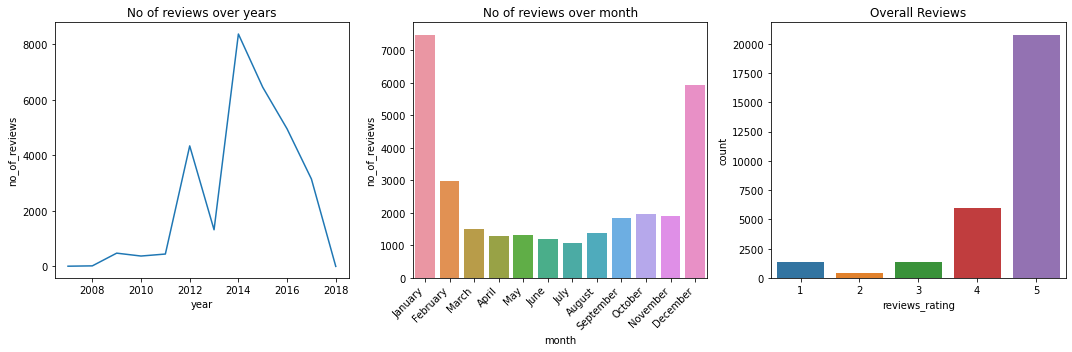

In [33]:
# Split the date into seperate columns of date month and year
# Extract date from the reviews_date column

reviews['reviews_onlydate'] = reviews['reviews_date'].str[:10]
reviews['reviews_onlydate'].head()

# Split the date into seperate columns of date month and year
# Set the datatype to the above extracted date column

reviews['reviews_onlydate'] = pd.to_datetime(reviews['reviews_onlydate'], errors='coerce').dt.date
reviews['reviews_onlydate'].fillna(reviews['reviews_onlydate'].value_counts().idxmax(),inplace=True)
reviews['reviews_onlydate'] = pd.to_datetime(reviews.reviews_onlydate, format='%Y-%m-%d')
reviews['reviews_onlydate'].head()

# Split the date into seperate columns of date month and year

reviews['month'] = reviews['reviews_onlydate'].dt.month
reviews['year'] = reviews['reviews_onlydate'].dt.year
f, axes = plt.subplots(1,3, figsize=(15,5))

# Yearly Reviews

yearly = reviews.groupby(['year'])['reviews_username'].count().reset_index()
yearly = yearly.rename(columns={'reviews_username':'no_of_reviews'})
yearChart = sns.lineplot(x='year',y='no_of_reviews',data=yearly, ax = axes[0])
yearChart.set_title('No of reviews over years')

# Monthly Reviews

monthly = reviews.groupby(['month'])['reviews_username'].count().reset_index()
monthly['month'] = monthly['month'].apply(lambda x : calendar.month_name[x])
monthly = monthly.rename(columns={'reviews_username':'no_of_reviews'})
monthChart = sns.barplot(x='month',y='no_of_reviews',data=monthly, ax = axes[1])
monthChart.set_title('No of reviews over month')
monthChart.set_xticklabels(monthChart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')

# Getting overall ratings for all products

sns.countplot(x = 'reviews_rating', data = reviews, ax = axes[2] ).set_title('Overall Reviews')

f.tight_layout()

Rating trend over the years

There is a significant increase in number of ratings given by users during 2013 to 2015 whereas from 2016 there is a sharp decline.
The total number of reviews given are high during December and January.

### Text Preprocessing

In [34]:
clean_reviews = reviews[['id','name', 'review_combined', 'user_sentiment']]
clean_reviews.head()

,id,name,review_combined,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,1
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor. This review was collected as part of a promotion.,1
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor.,1
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,"Disappointed. I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",0
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation. My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,0


In [35]:
clean_reviews['review_text_cleaned']=clean_reviews['review_combined'].str.lower() # to make all letters lower

In [36]:
#This function splits the words to letters, remove punctuations and join the words back
def remove_chars(text):
    revised_text = "".join([c for c in text if c not in string.punctuation])
    return revised_text

In [37]:
#removing punctions
clean_reviews['review_text_cleaned'] = clean_reviews['review_text_cleaned'].apply(lambda x: remove_chars(x))

In [38]:
stop_words = set(stopwords.words('english'))
wordnet = WordNetLemmatizer()

In [39]:
def StopWordRemoval(text):
    words = [wordnet.lemmatize(word) for word in text.split() if word.isalpha() and word not in stop_words]
    words = " ".join(words)
    return words

In [40]:
%%time 

clean_reviews['review_text_cleaned'] = clean_reviews['review_text_cleaned'].apply(lambda x: StopWordRemoval(x))
clean_reviews.head()

Wall time: 8.95 s


,id,name,review_combined,user_sentiment,review_text_cleaned
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,1,awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor. This review was collected as part of a promotion.,1,good good flavor review collected part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor.,1,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,"Disappointed. I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",0,disappointed read review looking buying one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant le money le mess
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation. My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,0,irritation husband bought gel u gel caused irritation felt like burning skin wouldnt recommend gel


In [41]:
# assigning word cloud 
wordcloud = WordCloud(background_color='black', stopwords = stop_words,max_words = 300,
                    max_font_size = 100, random_state = 42, width=800, height=400)

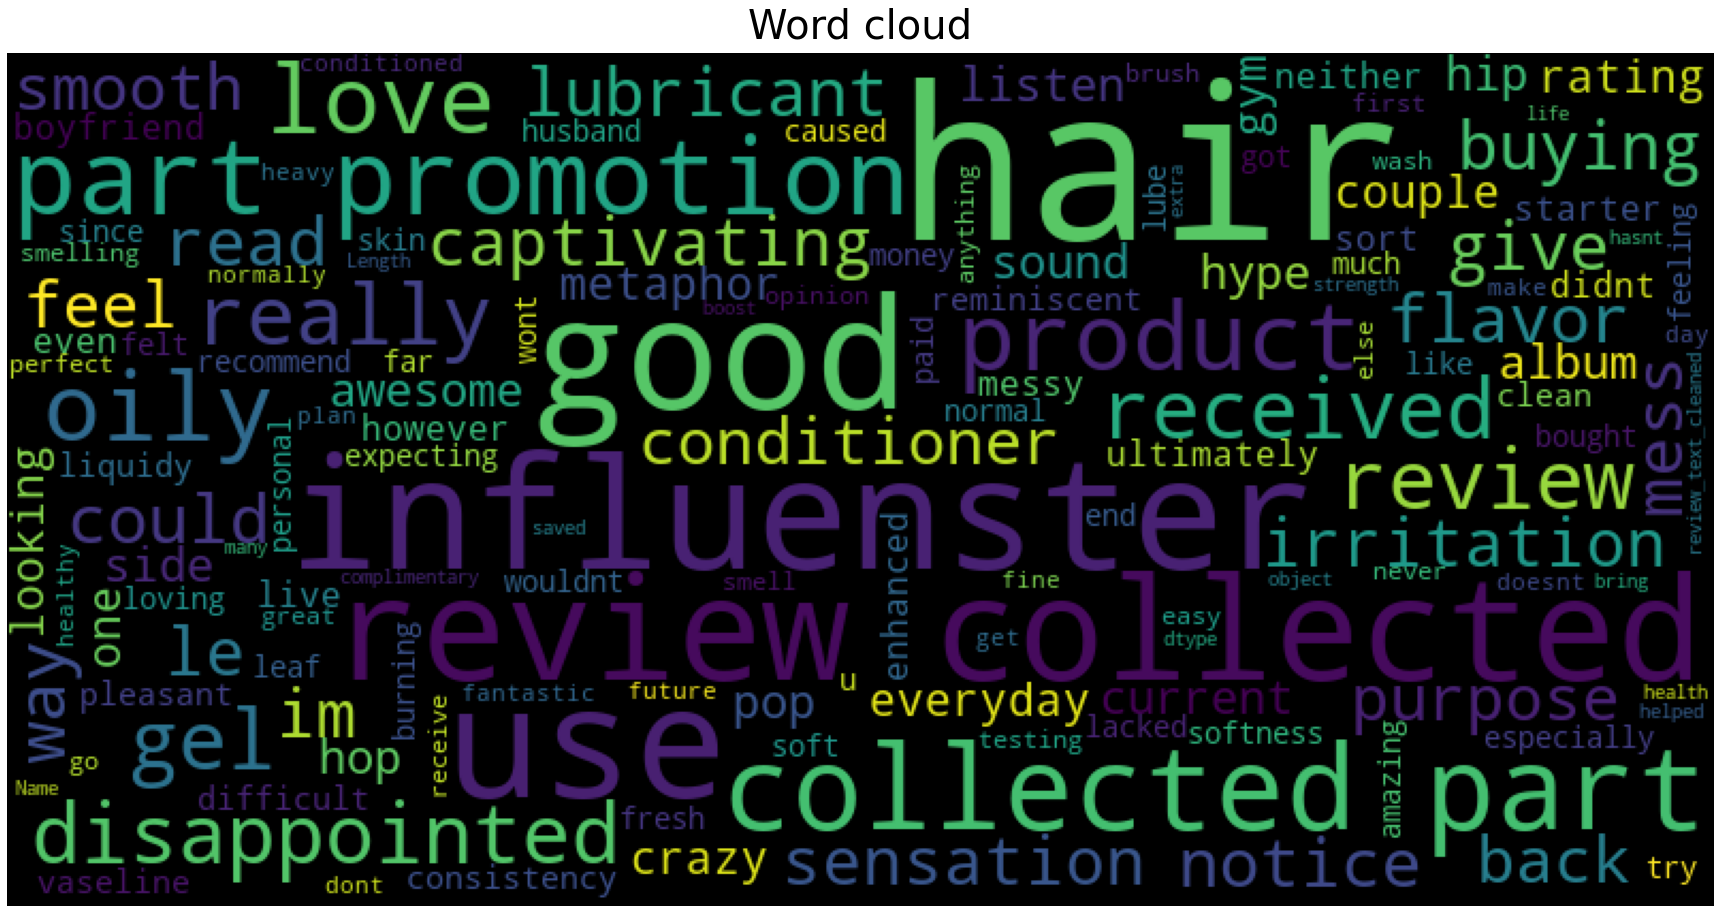

In [42]:
#Using a word cloud find the frequent words in the corpus

wordcloud.generate(str(clean_reviews['review_text_cleaned']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Word cloud", fontdict={'size': 40, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

In [43]:

#Function that to return most common words.using which we can derive common +ve & -ve words.

def MostCommonWords(reviews, n_most_common):
    # flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]


    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]


    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)

In [44]:
pos_reviews = clean_reviews[clean_reviews['user_sentiment']==1]
MostCommonWords(pos_reviews['review_text_cleaned'],20)

[('great', 14331),
 ('love', 11371),
 ('product', 10805),
 ('movie', 9855),
 ('review', 8861),
 ('part', 8728),
 ('promotion', 8374),
 ('collected', 8373),
 ('wipe', 8036),
 ('use', 7938),
 ('clean', 6128),
 ('clorox', 5956),
 ('good', 5759),
 ('easy', 3851),
 ('like', 3747),
 ('smell', 3431),
 ('one', 3427),
 ('hair', 3309),
 ('best', 2812),
 ('work', 2572)]

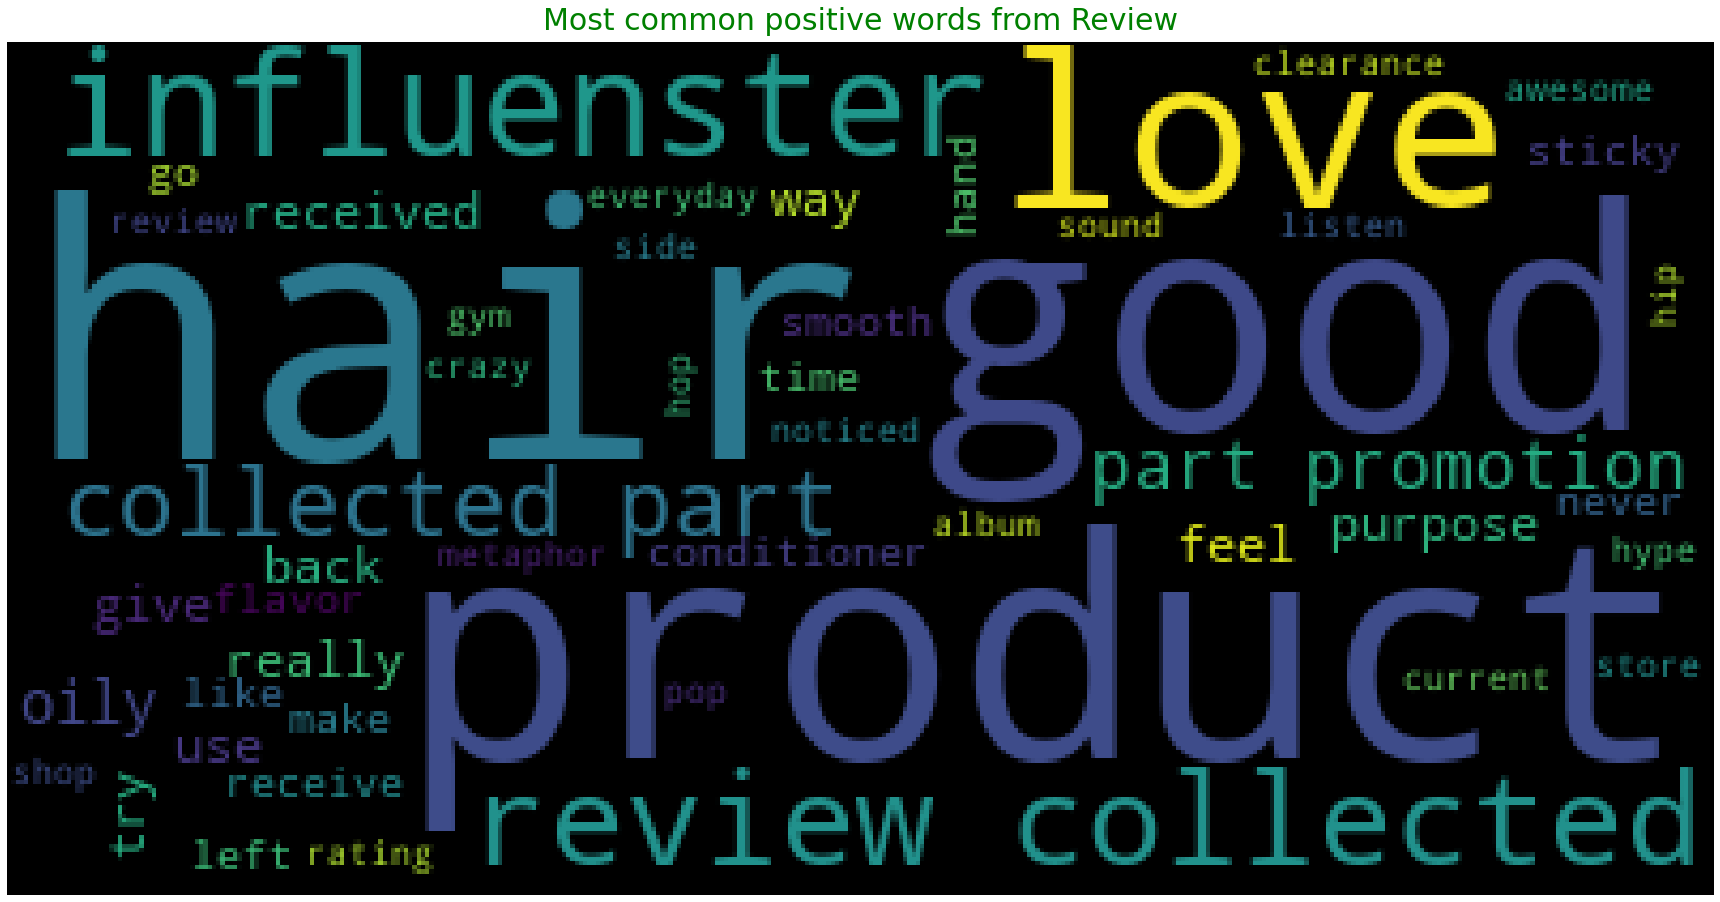

In [45]:
# to see the positive reviews wordcloud
wordcloud = WordCloud(stopwords=stop_words,max_words=50).generate(str(pos_reviews.review_text_cleaned))

wordcloud.generate(str(pos_reviews['review_text_cleaned']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Most common positive words from Review", fontdict={'size': 30, 'color': 'Green', 
                                  'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

In [46]:
neg_reviews = clean_reviews[clean_reviews['user_sentiment']==0]
MostCommonWords(neg_reviews['review_text_cleaned'],20)

[('product', 1934),
 ('hair', 1575),
 ('formula', 1445),
 ('new', 1249),
 ('old', 1057),
 ('movie', 1033),
 ('like', 1012),
 ('good', 984),
 ('gel', 876),
 ('back', 870),
 ('used', 733),
 ('smell', 701),
 ('would', 695),
 ('year', 641),
 ('one', 635),
 ('great', 622),
 ('review', 598),
 ('use', 573),
 ('conditioner', 549),
 ('bring', 527)]

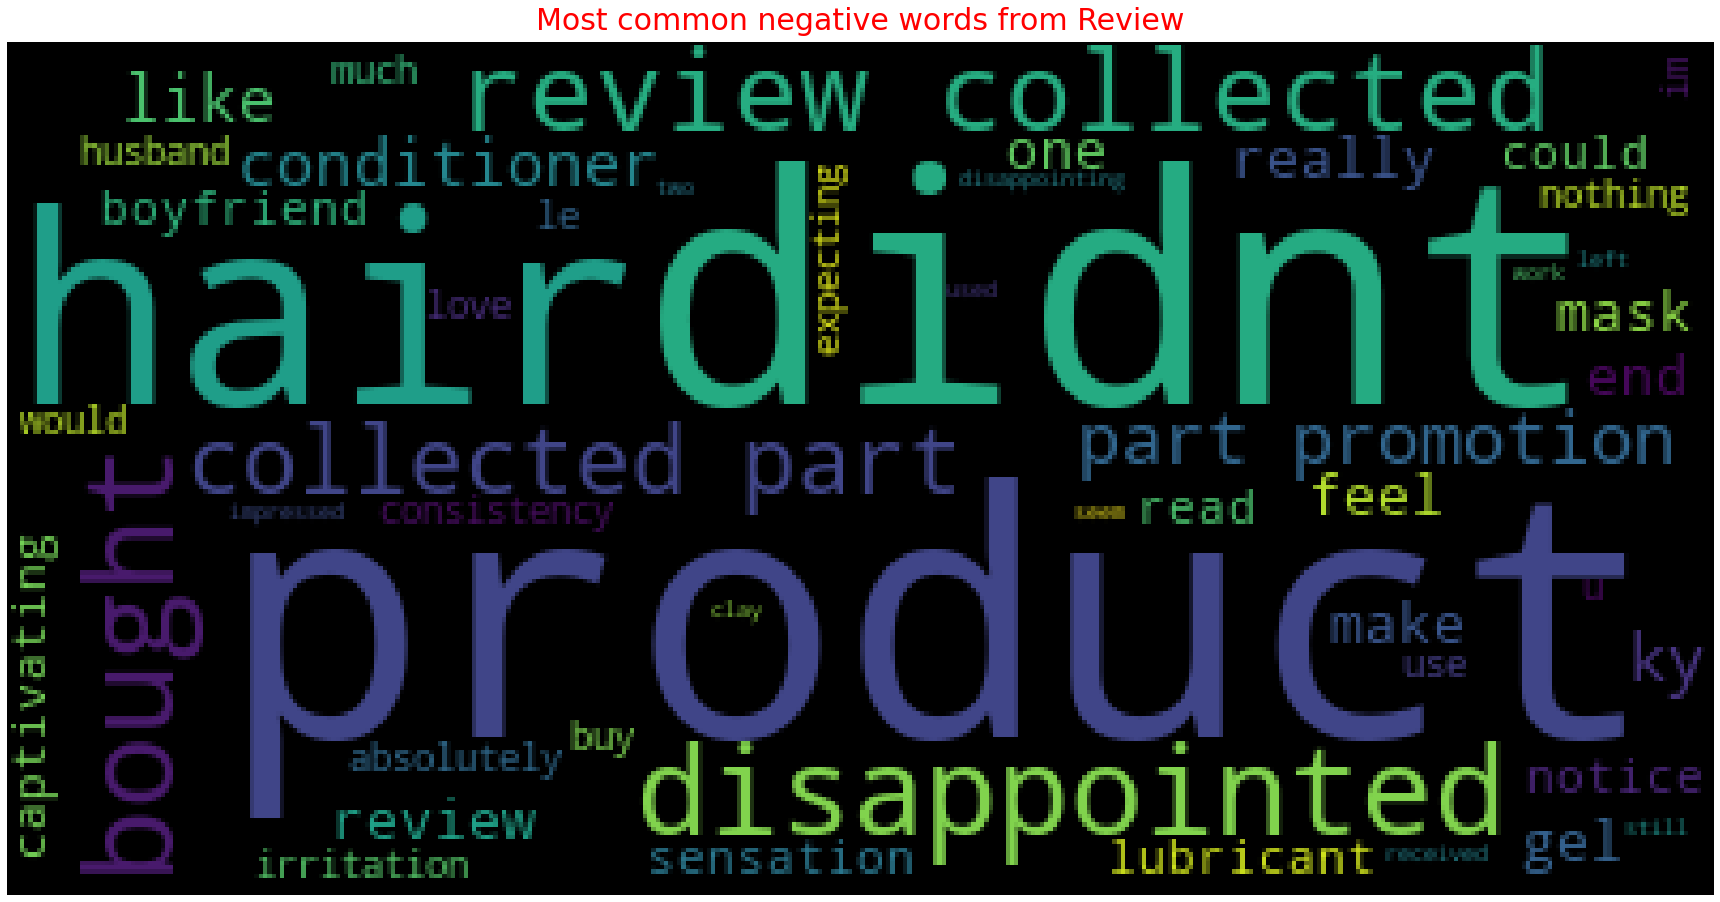

In [47]:
# to see the negative reviews wordcloud
wordcloud = WordCloud(stopwords=stop_words,max_words=50).generate(str(neg_reviews.review_text_cleaned))

wordcloud.generate(str(neg_reviews['review_text_cleaned']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Most common negative words from Review", fontdict={'size': 30, 'color': 'Red', 
                                  'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

In [48]:
#function to collect the n-gram frequency of words
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [49]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(pos_reviews['review_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 1]]


,0,1
0,review collected,8372
1,collected promotion,8372
2,clorox wipe,2808
3,great product,1937
4,great movie,1735
5,easy use,1523
6,love clorox,1206
7,love product,1117
8,good movie,909
9,disinfecting wipe,841


In [50]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(neg_reviews['review_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 2]]


,0,1
0,new formula,520
1,old formula,512
2,review collected,369
3,collected promotion,369
4,bring old,360
5,exxtra gel,205
6,shampoo conditioner,150
7,gel year,125
8,product year,124
9,received product,119


In [51]:
X = clean_reviews['review_text_cleaned']
y = clean_reviews['user_sentiment']

### Feature Extraction

In [52]:
#using TF-IDF vectorizer using the parameters to get 650 features.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True, 
                                   ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(clean_reviews['review_text_cleaned'])

y= clean_reviews['user_sentiment']

In [53]:
print(tfidf_vectorizer.get_feature_names_out())

['able' 'absolutely' 'absolutely love' 'acting' 'action' 'action movie'
 'actor' 'actually' 'add' 'adult' 'age' 'ago' 'amazing' 'apply' 'area'
 'available' 'away' 'awesome' 'awesome movie' 'awesome product' 'awful'
 'baby' 'bad' 'bag' 'bathroom' 'bathroom kitchen' 'beautiful' 'bee'
 'believe' 'best' 'best buy' 'best product' 'better' 'big' 'bit' 'black'
 'bleach' 'blu' 'blu ray' 'bluray' 'body' 'bottle' 'bought' 'box' 'boy'
 'brand' 'bring' 'bring cocoa' 'bring old' 'brown' 'burt' 'burt bee' 'buy'
 'buying' 'came' 'canister' 'car' 'care' 'carpet' 'carry' 'cast' 'cd'
 'chair' 'change' 'changed' 'character' 'child' 'chip' 'classic'
 'classroom' 'clay' 'clean' 'clean bathroom' 'clean fresh' 'clean great'
 'clean love' 'clean mess' 'clean review' 'clean smell' 'clean ups'
 'clean use' 'cleaned' 'cleaner' 'cleaning' 'cleaning product' 'cleanup'
 'clear' 'clorox' 'clorox disinfecting' 'clorox love' 'clorox product'
 'clorox review' 'clorox wipe' 'close' 'cocoa' 'cold' 'collected'
 'collected

In [54]:
# splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=42, test_size=0.25)

In [55]:
#Earlier we noticed a class imbalance in the user sentiments., we have to handle it now using SMOTE technique.
round(y.value_counts(normalize=True)*100,2)

1    89.53
0    10.47
Name: user_sentiment, dtype: float64

In [56]:
# Handling class imbalance using SMOTE techniques

# Applying counter

counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset

X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 20087, 0: 2365})
After Counter({1: 20087, 0: 20087})


### Model Building

In [57]:
def model(X_train,y_train,X_test,y_test,classifier):
    '''this function gives modeling results and confusion matrix also'''
    train_word_features,test_word_features,y_train,y_test = X_train,X_test,y_train,y_test
    classifier.fit(train_word_features, y_train)
    
    # calculating results 
    y_pred_train = classifier.predict(train_word_features)
    y_pred = classifier.predict(test_word_features)
    
    #for smart printing (learned from our lead instructor Bryan Arnold)
    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
    print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {balanced_accuracy_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(cm)
    plt.show()
    
    result_metrics = [] 
    accuracyTrain = metrics.accuracy_score(y_train, y_pred_train)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1score = metrics.f1_score(y_test, y_pred)
    #y_pred_prob = self.model.predict_proba(x_test)[:,1]
    #roc_auc = metrics.roc_auc_score(y_test, y_pred)

    print(f"Train Accuracy is : {accuracyTrain*100:.1f}%")
    print(f"Test Accuracy is : {accuracy*100:.1f}%")
    print(f"Precision is : {precision*100:.1f}%")
    print(f"Recall is : {recall*100:.1f}%")
    print(f"F1 Score is : {f1score*100:.1f}%")
    #print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")

    result_metrics.append(accuracyTrain)
    result_metrics.append(accuracy)
    result_metrics.append(precision)
    result_metrics.append(recall)
    result_metrics.append(f1score)
   # result_metrics.append(roc_auc)
    return result_metrics

### Model 1 - Logistic Regression


Accuracy:
TRAIN: 0.8932145168516952
TEST: 0.8781400320684126

Balanced Accuracy:
TRAIN: 0.8932145168516952
TEST: 0.8251546487471421


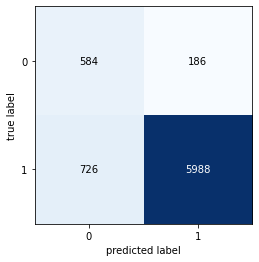

Train Accuracy is : 89.3%
Test Accuracy is : 87.8%
Precision is : 97.0%
Recall is : 89.2%
F1 Score is : 92.9%


In [58]:
# choosing classifier and running model
classifier = LogisticRegression(class_weight = "balanced", C=0.5, solver='sag')
lr_metrics=model(X_train,y_train,X_test,y_test,classifier)

### Model 2 - Naive Bayes

Accuracy:
TRAIN: 0.8218001692637029
TEST: 0.8094601817210048

Balanced Accuracy:
TRAIN: 0.8218001692637029
TEST: 0.8144706351140667


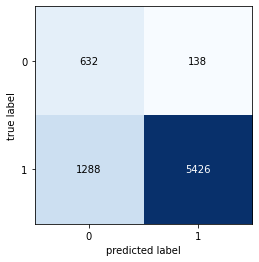

Train Accuracy is : 82.2%
Test Accuracy is : 80.9%
Precision is : 97.5%
Recall is : 80.8%
F1 Score is : 88.4%


In [59]:
# Fitting Naive Bayes Model
mnb = MultinomialNB(alpha=1.0)
mnb_modebuilder = model(X_train,y_train, X_test, y_test,mnb) 

### Model 3 - Decision Tree

Accuracy:
TRAIN: 0.8351919151690148
TEST: 0.7807322287546766

Balanced Accuracy:
TRAIN: 0.8351919151690148
TEST: 0.7524689638630657


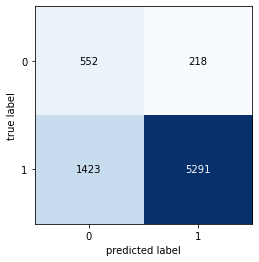

Train Accuracy is : 83.5%
Test Accuracy is : 78.1%
Precision is : 96.0%
Recall is : 78.8%
F1 Score is : 86.6%


In [60]:
# Fitting Decision Tree Model

d_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5, 
                                        random_state=42, class_weight='balanced')
dt_metrics_cv=model(X_train,y_train,X_test,y_test,d_tree)

### Model 4 - Random Forest Classifier

Accuracy:
TRAIN: 0.9992781400906059
TEST: 0.9254409406734366

Balanced Accuracy:
TRAIN: 0.9992781400906059
TEST: 0.7727589955471993


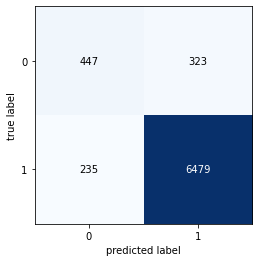

Train Accuracy is : 99.9%
Test Accuracy is : 92.5%
Precision is : 95.3%
Recall is : 96.5%
F1 Score is : 95.9%


[0.9992781400906059,
 0.9254409406734366,
 0.952513966480447,
 0.964998510574918,
 0.9587155963302754]

In [61]:
# Fitting a Random Forest classifier without any hyperparameter tuning

rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")
model(X_train,y_train,X_test,y_test,rf)

In [62]:
# Fitting a Random Forest classifier with various hyperparameters
# Create the parameter grid based on the results of random search

params = {
    'max_depth': [2,3,5,10,100],
    'min_samples_leaf': [5,10,20,50,70],
    'n_estimators': [10, 25, 50,70, 100]
}

In [63]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1")

In [64]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 125 candidates, totalling 500 fits
Wall time: 4min 11s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 100],
                         'min_samples_leaf': [5, 10, 20, 50, 70],
                         'n_estimators': [10, 25, 50, 70, 100]},
             scoring='f1', verbose=1)

In [65]:
# Print best hyperparameters

rf_best = grid_search.best_estimator_
print(rf_best)

RandomForestClassifier(max_depth=100, min_samples_leaf=5, n_estimators=50,
                       oob_score=True, random_state=42)


In [ ]:
rf1 = RandomForestClassifier(oob_score=True, random_state=42,max_depth=100, min_samples_leaf=5)
rf_metrics=model(X_train,y_train,X_test,y_test,rf1)

### Model 5 - XGBoost Classifier

In [ ]:
xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree',
                      num_class = 3, eval_metric = 'merror',
                        eta = .1,max_depth = 12, colsample_bytree = .4, learning_rate = 0.1,
                        max_delta_step=1)
xg_metrics=model(X_train,y_train,X_test,y_test,xgb)

### Comparison of performance between models

In [ ]:
# Creating a table which contain all the metrics

metrics_table = {'Metric': ['Train Accuracy','Test Accuracy','Precision','Recall','F1Score'], 
        'Logistic Regression': lr_metrics,
        'Naive Bayes': mnb_modebuilder,
        'Decision Tree': dt_metrics_cv,
        'Random Forrest': rf_metrics,
        'XGB': xg_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression','Naive Bayes','Decision Tree','Random Forrest',
                                                    'XGB'] )

df_metrics

#### Saving the model

In [ ]:
def save_object(obj, filename):
    filename = "pickle\\"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [ ]:
save_object(xgb, 'sentiment-xg-boost-model')

In [ ]:
save_object(tfidf_vectorizer, 'tfidf-vectorizer')

In [ ]:
save_object(clean_reviews, 'cleaned_data')

### Recommendation System

- User based recommendation
- User based prediction & evaluation
- Item based recommendation
- Item based prediction & evaluation

Different Approaches to develop Recommendation System -

    Demographich based Recommendation System
    Content Based Recommendation System
    Collaborative filtering Recommendation System

Different Approaches to develop Recommendation System -

Here we are going to try with 2 of the Colloboarative filtering techniques:
 -   - User-User Based Approach
 -   - Item-Item Based Approach

In [ ]:
reviews.info()

In [ ]:
df_recommendation = reviews[["id", "name", "reviews_rating", "reviews_username"]]

In [ ]:
df_recommendation.isna().sum() # Checking for null values


In [ ]:
#Dividing the dataset into train and test

train, test = train_test_split(df_recommendation, test_size=0.25, random_state=42)

print(train.shape)
print(test.shape)

In [ ]:
product_col = "id"
user_col = "reviews_username"
value_col = "reviews_rating"

In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
df_pivot = pd.pivot_table(train,index=user_col, columns = product_col, values = value_col).fillna(0)
df_pivot.head(10)

### Creating dummy train and test

In [ ]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()
dummy_train.head()

In [ ]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train[value_col] = dummy_train[value_col].apply(lambda x: 0 if x>=1 else 1)

In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index=user_col, columns = product_col, values = value_col).fillna(1)
dummy_train.head(10)

#### Cosine Similarity

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case]

#### Adjusted Cosine

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.

### User similarity matrix

In [ ]:
df_pivot.index.nunique()

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

In [ ]:
#using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

In [ ]:
print(user_correlation.shape)

### Prediction User-User

In [ ]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

In [ ]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

In [ ]:
#since we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

### Find 20 recommendation for the user

In [ ]:
user_input = "08dallas" 
print(user_input)

In [ ]:
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations

In [ ]:
#display the top 20 product id, name and similarity_score 
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : round(recommendations,2)})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

### Evaluation User-User

In [ ]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

In [ ]:
common.head()

In [ ]:
# convert into the user-movie matrix.
common_user_based_matrix = pd.pivot_table(common,index=user_col, columns = product_col, values = value_col)
common_user_based_matrix.head()

In [ ]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

In [ ]:
user_correlation_df[user_col] = df_pivot.index
user_correlation_df.set_index(user_col,inplace=True)
user_correlation_df.head()

In [ ]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape

In [ ]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [ ]:
user_correlation_df_3 = user_correlation_df_2.T

In [ ]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

In [ ]:
dummy_test = common.copy()

dummy_test[value_col] = dummy_test[value_col].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index=user_col, columns = product_col, values = value_col).fillna(0)

In [ ]:
dummy_test.shape

In [ ]:
common_user_based_matrix.head()

In [ ]:
dummy_test.head()

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [ ]:
common_user_predicted_ratings.head()

In [ ]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [ ]:
common_ = pd.pivot_table(common,index=user_col, columns = product_col, values = value_col)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

### Item Based Recommendation

In [ ]:
df_pivot = pd.pivot_table(train,
    index=product_col,
    columns=user_col,
    values=value_col
)

df_pivot.head()

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [ ]:
df_subtracted.head()

In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

In [ ]:
### Prediction - item-item


In [ ]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

In [ ]:
#### Filtering the rating only for the products not rated by the user for recommendation

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

### Finding the top 20 recommendation for the user

In [ ]:
# Take the user ID as input
user_input = '08dallas'
print(user_input)

In [ ]:
# Recommending the Top 5 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

In [ ]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

### Evaluation - item-item

In [ ]:
common =  test[test.id.isin(train.id)]
common.shape

In [ ]:
common.head(4)

In [ ]:
common_item_based_matrix = common.pivot_table(index=product_col, columns=user_col, values=value_col)

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

In [ ]:
item_correlation_df[product_col] = df_subtracted.index
item_correlation_df.set_index(product_col,inplace=True)
item_correlation_df.head()

In [ ]:
list_name = common.id.tolist()

item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [ ]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [ ]:
df_subtracted

In [ ]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

In [ ]:
dummy_test = common.copy()
dummy_test[value_col] = dummy_test[value_col].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index=product_col, columns=user_col, values=value_col).fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [ ]:
common_ = pd.pivot_table(common,index=product_col, columns=user_col, values=value_col)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

In [ ]:
# saving the correlation matrix of user based recommender 
save_object(user_final_rating, "user_final_rating")

#### Top Product Recommendations - Recommendation of 20 products and filtering by sentiment model

In [ ]:
#Get the top 20 product recommendations using the recommender system and get the top 5 using the sentiment ML model.. the similar method would be used in above model 

In [ ]:
def get_sentiment_recommendations(user):
    if (user in user_final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = clean_reviews[clean_reviews.id.isin(recommendations)]
        #temp["reviews_text_cleaned"] = temp["reviews_text"].apply(lambda x: self.preprocess_text(x))
        #transfor the input data using saved tf-idf vectorizer
        X =  tfidf_vectorizer.transform(temp["review_text_cleaned"].values.astype(str))
        temp["predicted_sentiment"]= xgb.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [ ]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations("08dallas")

In [ ]:
#get the top 5
get_sentiment_recommendations("08dallas")[:5]

In [ ]:
#testing the above fuction on the user that doesn't exists or a new user
get_sentiment_recommendations("test123")

In [ ]:
X_sample = tfidf_vectorizer.transform(["Awesome product, will recommend"])
y_pred_sample = xgb.predict(X_sample)
y_pred_sample

In [ ]:
X_sample = tfidf_vectorizer.transform(["worst product, quality is poor"])
y_pred_sample = xgb.predict(X_sample)
y_pred_sample

Thus, we have created a Recommendation engine and a Classification model which will provide Sentiment based product recommendations to users.